Load Dataset

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import pickle

# load data using pickle
with open("attention_dataset.pkl", "rb") as f:
    """
    attention_data: dimension (num_samples, iteration, layer, 
                                1 #batch during generation, 
                                num_heads, seq_len, seq_len)
    reward_data: list of rewards (num_samples)
    """
    attention_data, reward_data = pickle.load(f)

# AttentionDataset class
class AttentionDataset:
    def __init__(self, attentions, rewards):
        self.attentions = attentions
        self.rewards = rewards
        self.dataset_size = len(rewards)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        return self.attentions[idx], self.rewards[idx]
    
def attention_collate_fn(batch):
    attentions, rewards = zip(*batch)
    return list(attentions), torch.tensor(rewards)
attention_dataset = AttentionDataset(attention_data, reward_data)
attention_loader = DataLoader(attention_dataset, batch_size=32, shuffle=False, collate_fn=attention_collate_fn)

Adverserial Model (split into stages and combined at the end)

In [3]:
# code to convert the attention data to a graph
import networkx as nx
import numpy as np

# Create the graph structure from the attention weights
def attention_to_graph(attention):
    # Get the number of nodes
    n = attention.shape[-1] # number of tokens

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes from attention
    for i in range(n):
        # TODO: weight dependend on the number of the tokens
        G.add_node(f'token_{i}', weight=1.0)
    
    # Add edges from attention
    for i in range(n):
        for j in range(n):
            if (j <= i): # attention masking
                G.add_edge(f'token_{i}', f'token_{j}', weight=attention[i, j])

    # TODO: Check for further aggregation for transformer input
    return G

Attention data shape: torch.Size([4, 4])
Attention data: 100
Attention data: 3
Nodes:
token_0: {'weight': 1.0}
token_1: {'weight': 1.0}
token_2: {'weight': 1.0}
token_3: {'weight': 1.0}

Edges:
token_0 -> token_0: {'weight': tensor(1.)}
token_1 -> token_0: {'weight': tensor(0.9415)}
token_1 -> token_1: {'weight': tensor(0.0585)}
token_2 -> token_0: {'weight': tensor(0.8502)}
token_2 -> token_1: {'weight': tensor(0.1181)}
token_2 -> token_2: {'weight': tensor(0.0317)}
token_3 -> token_0: {'weight': tensor(0.5574)}
token_3 -> token_1: {'weight': tensor(0.3306)}
token_3 -> token_2: {'weight': tensor(0.0684)}
token_3 -> token_3: {'weight': tensor(0.0436)}


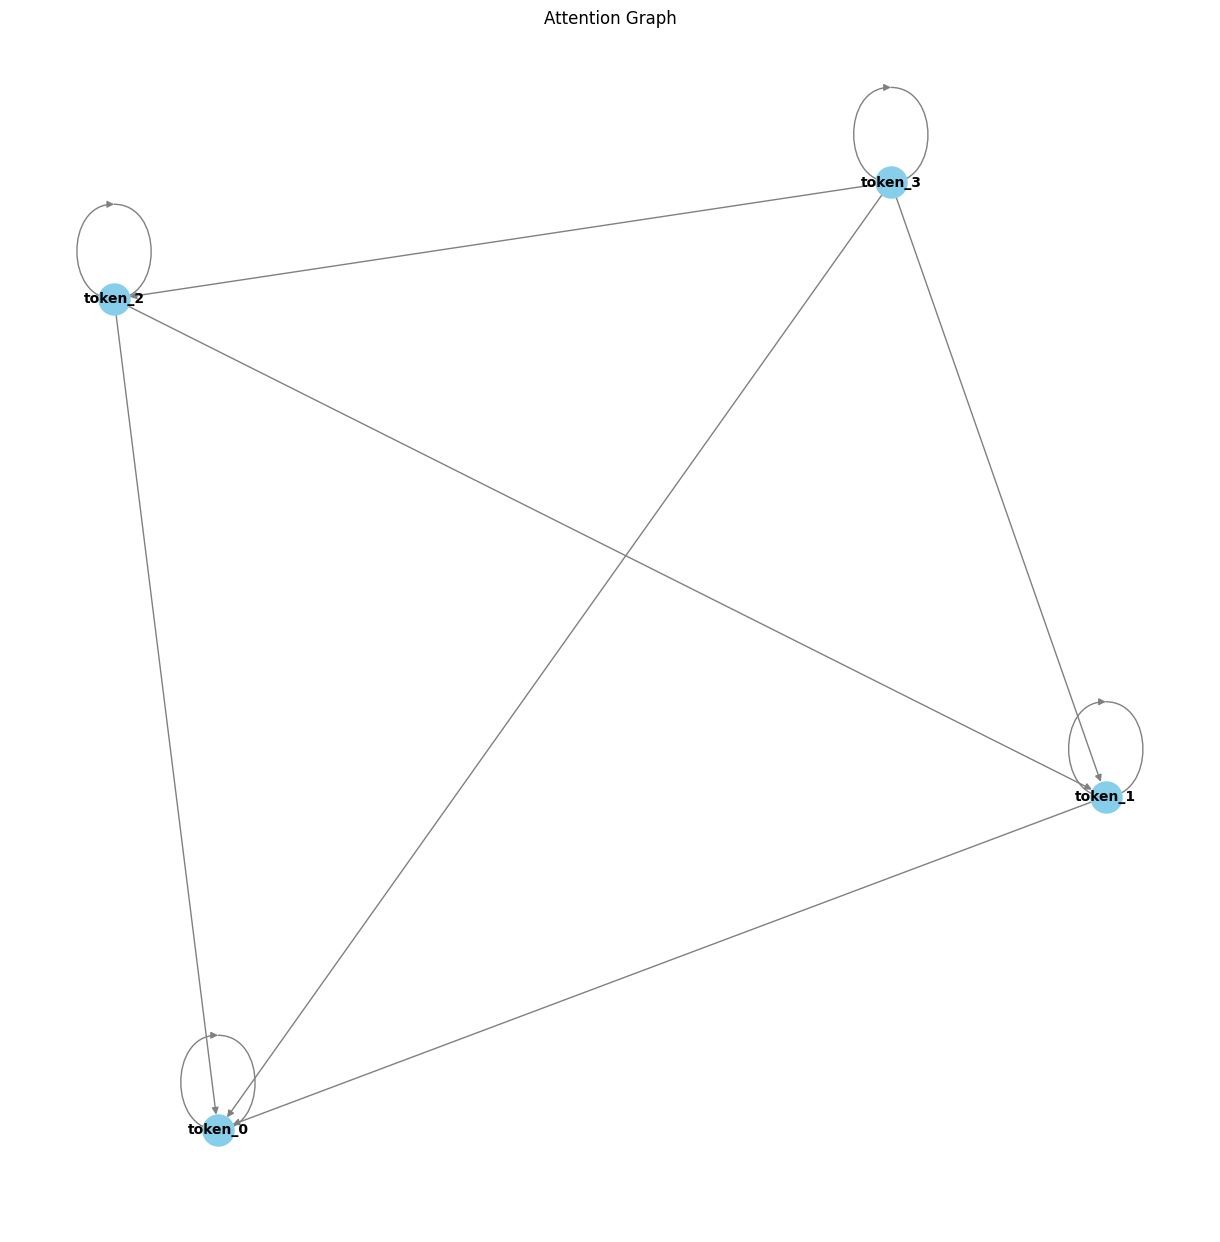

In [4]:
# Test the attention_to_graph function
import matplotlib.pyplot as plt

print("Attention data shape:", attention_data[0][0][0][0][0].shape)  # Check the shape of the attention data
print("Attention data:", len(attention_data))  # Check the attention data
print("Attention data:", len(attention_data[0]))  # Check the attention data
test_graph = attention_to_graph(attention_data[0][0][0][0][0])

def print_graph_details(G):
    print("Nodes:")
    for node, data in G.nodes(data=True):
        print(f"{node}: {data}")
    
    print("\nEdges:")
    for u, v, data in G.edges(data=True):
        print(f"{u} -> {v}: {data}")

print_graph_details(test_graph)

# Function to plot the graph
def plot_graph(G):
    pos = nx.spring_layout(G)  # Layout for visualization
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
    plt.title('Attention Graph')
    plt.show()

plot_graph(test_graph)

In [28]:
# # Test the graph creation for a whole batch
# attention_graph_data = []
# for batch in attention_loader:
#     # batch: (num_samples, iteration, layer, 1, num_heads, seq_len, seq_len), rewards: (num_samples)
#     attentions, rewards = batch
#     attention_data_batch = []
#     for attention_token in attentions[:]:
#         # attention_step: (iteration, layer, 1, num_heads, seq_len, seq_len)
#         print("Attention step")
#         attention_data_step = []
#         for token in attention_step[:]:
#             print("Token")
#             # token: (layer, 1, num_heads, seq_len, seq_len)
#             attention_data_head = []
#             for head in token[0][:]:
#                 # head: (1, num_heads, seq_len, seq_len)
#                 G = attention_to_graph(head)
#                 attention_data_head.append(G)
#             attention_data_step.append(attention_data_head)
#         attention_data_batch.append(attention_data_step)
#     attention_graph_data.append(attention_data_batch)
#     break

# Test graph creation for a whole batch
attention_graph_data = []
for batch in attention_loader:
    # batch: (num_samples, iteration, layer, 1, num_heads, seq_len, seq_len), rewards: (num_samples)
    attentions, rewards = batch
    attention_data_batch = []
    for attention_iteration in attentions[:]:
        # attention_iteration: (iteration, layer, 1, num_heads, seq_len, seq_len)
        attention_data_step = []
        for attention_layer in attention_iteration[:]:
            # attention_layer: (layer, 1, num_heads, seq_len, seq_len)
            attention_data_head = []
            for attention_head in attention_layer[0][:]:
                # attention_head: (1, num_heads, seq_len, seq_len)
                G = attention_to_graph(attention_head)
                attention_data_head.append(G)
            attention_data_step.append(attention_data_head)
        attention_data_batch.append(attention_data_step)
    attention_graph_data.append(attention_data_batch)
    break

In [29]:
print("Attention Graph Data Shape:", len(attention_graph_data))  # Check the shape of the attention graph data
print("Attention Graph Data:", len(attention_graph_data[0]))  # Check the attention graph data
print("Attention Graph Data:", len(attention_graph_data[0][0]))  # Check the attention graph data
print("Attention Graph Data:", len(attention_graph_data[0][0][0]))  # Check the attention graph data
print("Attention Graph Data:", len(attention_graph_data[0][0][0][0]))  # Check the attention graph data

Attention Graph Data Shape: 1
Attention Graph Data: 32
Attention Graph Data: 3
Attention Graph Data: 1
Attention Graph Data: 4


In [6]:
# imports for the GNN model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric.utils as pyg_utils
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

c:\Users\leonh\anaconda3\envs\adverserialAlignment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
